## Title: Primer on Variational Inference and its application to Deep Learning

Abstract: Variational inference belongs to a class of statistical inference techniques and proved to be a workhorse in the area of generative modelling in machine learning community. In this primer we will cover some necessary theory to provide better understanding of this class of inference techniques. We will also discuss application of variational inference to Deep Learning, namely Variational Autoencoders (VAEs). Finally, some results from our research on de-novo design of metabolic enzymes, using VAEs, will be presented. 

# Primer on Variational Inference

1. Very brief introduction
2. Kullback-Leibler divergence
3. Importance Sampling
4. Variational Inference
5. Mean-Field Variational Inference:
    - 5.1 Variational Inference applied to Gaussian Mixture Model
    - 5.2 Variational Inference applied to Ising Model
6. From Mean-field VI to Stochastic VI:
    - 6.1 SVI Pytorch example on 1D dataset
    - 6.2 Backpropagation using discrete distributions
7. Application of VI to enzyme engineering

## 1. Very brief introduction
Probabilistic models is an alternative to more traditional deterministic models:
 - data is often noisy, non-stationary
 - we may want to incorporate our prior beliefs into the model

The **central** element of probabilistic models is **statistical inference**: any technique that we use to come up with estimates of probabilities incorporated into our model:
 - MLE
 - MAP
 - MCMC
 - Laplace Approximation
 - Variational Inference

If there is one formula that tells nearly everything about statistical inference (and the problems that arise with it), it is **Bayes rule**:
\begin{equation*}
  p(z|y) =\frac{p(y,z)}{p(y)} = \frac{p(y|z)p(z)}{p(y)} = \frac{p(y|z)p(z)}{\int p(y,z)dz}
\end{equation*}


## 2. Kullback-Leibler divergence
Kullback-Leibler divergence $KL(p||q)$ is defined as:

\begin{equation*}
  KL(p||q) = \int p(x) \log \frac{p(x)}{q(x)} dx = \mathbb{E}_{p(x)}[\log \frac{p(x)}{q(x)}]
\end{equation*}

$KL(p||q)$ measures the difference between two distributions $p$ and $q$ and has following properties:
- $KL(p||q) \geq 0$ (non-negative)
- $KL(p||q) = 0$ iff $p=q$
- $KL(p||q) \neq KL(q||p) $

Why KL is non-negative?
 - Use Jensen's inequality for concave functions: $\log \mathbb{E}[g(x)] \geq \mathbb{E}[\log g(x)]$
 - Proof:
     
     $\mathbb{E}_{p(x)}[\log \frac{q(x)}{p(x)}] \leq \log \mathbb{E}_{p(x)}[\frac{q(x)}{p(x)}] = \log \int p(x) \frac{q(x)}{p(x)} dx = \log \int q(x) dx = \log 1 = 0$.
     
   If $\mathbb{E}_{p(x)}[\log \frac{q(x)}{p(x)}] \leq 0$, then $\mathbb{E}_{p(x)}[\log \frac{p(x)}{q(x)}] \geq 0$.
  

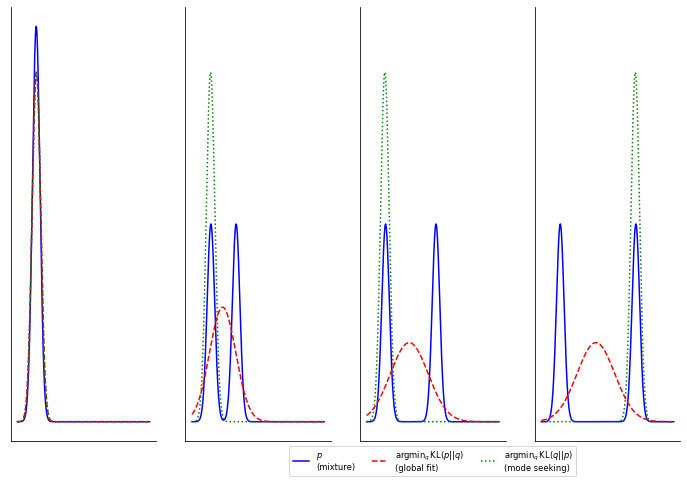

In [1]:
### credits to Tuan Anh Le
from KL_demo import KL_calculation_demo
KL_calculation_demo()

## 3. Importance Sampling
Estimate properties of a particular distribution by having samples from a different distribution (which is usually easy to sample from).
Let's assume problem of interest is estimating marginal likelihood:
\begin{equation*}
  p(y) = \int p(y,z)dz = \int p(y|z)p(z)dz
\end{equation*}
It may be difficult to do this integration, so Monte Carlo integration may be helpful. 
\begin{equation*}
  p(y) = \int p(y,z)dz = \int p(y|z)p(z)dz = \int p(y|z)p(z) \frac{q(z)}{q(z)}dz = \int p(y|z)\frac{p(z)}{q(z)}q(z)dz = \mathbb{E}_{q(z)}[p(y|z)\frac{p(z)}{q(z)}]
\end{equation*}
We can finally approximate the expectation with its MC estimate:
\begin{equation*}
  p(y) = \mathbb{E}_{q(z)}[p(y|z)\frac{p(z)}{q(z)}] \approx \frac{1}{N} \sum_{n=1}^{N} p(y|z^{n})\frac{p(z^{n})}{q(z^{n})}, z^{n} \sim q(z)
\end{equation*}

We have unbiased estimate but importance sampling scales poorly to high-dimensional data.
We may want a technique that scales well to high-dimensional data and is **deterministic** (i.e. no sampling required). This technique is Variational Inference.


## 4. Variational Inference

Let's see how else we can try to solve the problem of estimating marginal likelihood.
Start the same as before, i.e:
\begin{equation*}
  p(y) = \mathbb{E}_{q(z)}[p(y|z)\frac{p(z)}{q(z)}] = \mathbb{E}_{q(z)}[\frac{p(y,z)}{q(z)}]
\end{equation*}
Instead of working with probability, let's work with log-probability:
\begin{equation*}
  \log p(y) = \log \mathbb{E}_{q(z)}[p(y|z)\frac{p(z)}{q(z)}] = \log \mathbb{E}_{q(z)}[\frac{p(y,z)}{q(z)}]
\end{equation*}
By appplying concavity (see Jensen's inequality) of the logarithm, we get:
\begin{equation*}
  \log p(y) = \log \mathbb{E}_{q(z)}[\frac{p(y,z)}{q(z)}] \geq \mathbb{E}_{q(z)}[\log \frac{p(y,z)}{q(z)}]
\end{equation*}
Now let's take a closer look at the expected value of the logarith (of some function):
\begin{equation*}
  \mathbb{E}_{q(z)}[\log \frac{p(y,z)}{q(z)}] = \mathbb{E}_{q(z)}[\log p(y|z)] - KL(q(z)||p(z))
\end{equation*}
Finally, we get the following (**most important equation**):
\begin{equation*}
  \log p(y) \geq \mathbb{E}_{q(z)}[\log p(y|z)] - KL(q(z)||p(z)) = \mathbb{F}(y,q)
\end{equation*}

We want to maximize $\mathbb{F}(y,q)$ to have our lower bound as close as possible to data log-likelihood (also called model evidence).

Few important notes about $\mathbb{F}(y,q)$:
1. KL-term $KL(q(z)||p(z))$ is a "mode-seeking" KL-divergence (see note about KL-divergence).
2. The whole thing is called **Variational Free Energy**. The term **variational** comes from the fact that we want to maximize it w.r.t to a function $q(z)$.
3. Distribution $q(z)$ really depends on a data (i.e. $q(z|y)$), which makes it **variational posterior distribution** (true posterior is $p(z|y)$).

What have we achieved?
1. Integration is now optimisation: we optimize for $q(z)$. We will talk more about this!
2. Easy convergence criteria: check when $\mathbb{F}(y,q)$ stops changing.

It may be useful to distinguish between **Variational Inference (VI)** and **Variational Bayesian Inference (VB)**.
If we have a generative model $p(y|z,\theta)p(z|\theta)$ where $\theta$ are some parameters (i.e. weights in NN), then distinction is following:
1. In **VI**, we approximate only distribution of latent variable $q(z|y)$ and learn parameters $\theta$ by MLE. Example: Variational Autoencoder.
2. In **VB**, we approximate both latent variables and parameters with some variational distribution $q(z,\theta|y)$.

## 5. Mean-field Variational Inference
Let's dive into **Mean-Field Variational Inference** and **CAVI (Coordinate Ascent Variational Inference)**.

**Mean-field approximation** means the **factorization** of variational distribution:
\begin{equation*}
  q(z) = q(z_1 \cdots z_m) = \prod_{j=1}^{m} q(z_j)
\end{equation*}

**CAVI** means: fix all but one parameter, update that one parameter.

Let's see how mean-field and CAVI come into play when we want to maximize $\mathbb{F}(y,q)$.

Let's try to derive update equations in a generic form:

1. We notice that 
\begin{equation*}
\mathbb{F}(y,q) = \mathbb{E}_{q(z)}[\log p(y|z)] - KL(q(z)||p(z)) = \mathbb{E}_{q(z)}[\log p(y,z)] - \mathbb{E}_{q(z)}[\log q(z)]
\end{equation*}
The last term, $\mathbb{E}_{q(z)}[\log q(z)]$, is called an entropy term, denoted $\mathbb{H}({q(z)})$.

2. We rewrite the first term as follows: $\mathbb{E}_{q(z)}[\log p(y,z)] = \mathbb{E}_{q(z)}[\log p(y,z_{-j},z_{j})]$, where $z_{-j} = (z_1,z_2 \cdots z_{j-1},z_{j+1} \cdots)$.

3. Because of **mean-field** assumption, the second term can be written in the following way: $\mathbb{E}_{q(z)}[\log q(z)] = \sum_{j=1}^{K} \mathbb{E}_{q(z_j)}[\log q(z_j)]$.

4. Finally, combining all above we ge the following result:
\begin{equation*}
  \mathbb{F}(y,q) = \mathbb{E}_{q(z)}[\log p(y,z)] - \mathbb{E}_{q(z)}[\log q(z)] = \mathbb{E}_{q(z)}[\log p(y,z_{-j},z_{j})] - \sum_{j=1}^{K} \mathbb{E}_{q(z_j)}[\log q(z_j)]
\end{equation*}

5. Since we are doing **CAVI**, we need to isolate terms related to $z_j$, so we continue manipulating previous equation using [law of total expectation](https://en.wikipedia.org/wiki/Law_of_total_expectation): $\mathbb{E}(X) = \mathbb{E}(\mathbb{E}(X|Y))$:
\begin{equation*}
  \mathbb{F}(y,q) = \mathbb{E}_{q(z)}[\log p(y,z_{-j},z_{j})] - \sum_{j=1}^{K} \mathbb{E}_{q(z_j)}[\log q(z_j)] = \mathbb{E}_{q(z_j)}[\mathbb{E}_{q(z_{-j})}[\log p(y,z_{-j},z_{j})]|z_j] - \mathbb{E}_{q(z_j)}[\log q(z_j)] + const
\end{equation*}

6. Again, because we have **mean-field** assumption ,we can simply the term with conditional expectation:
\begin{equation*}
    \mathbb{E}_{q(z_{-j})}[\log p(y,z_{-j},z_{j})]|z_j] = \int \log p(y,z_{-j},z_{j}) q(z_{-j}|z_j) = \int \log p(y,z_{-j},z_{j}) q(z_{-j}) = \mathbb{E}_{q(z_{-j})}[\log p(y,z)]
\end{equation*}

7. Finally, putting all together:
\begin{equation*}
    \mathbb{F}(y,q_j,q_{-j}) = \mathbb{E}_{q(z_{j})}[\mathbb{E}_{q(z_{-j})}[\log p(y,z)]] - \mathbb{E}_{q(z_j)}[\log q(z_j)] + const
\end{equation*}

8. We want to maximize this $\mathbb{F}$ (see 7) w.r.t $q(z_j)$ ($q(z_{-j})$ is fixed). There are two ways to do so. One way involves differentiating $\mathbb{F}$ w.r.t $q(z_j)$, which is a function, so we need to apply functional derivative. We will not go this route but a reference to variational calculus will be provided. Another way is adopted from K.Murphy's ML:A Probabilistic Perspective.

    - Notice that you can combine terms under $\mathbb{E}_{q(z_{j})}$ to form a negative KL term: $\mathbb{E}_{q(z_{j})}[\mathbb{E}_{q(z_{-j})}[\log p(y,z)]] - \mathbb{E}_{q(z_j)}[\log q(z_j)] = -KL(q(z_{j})||\exp(\mathbb{E}_{q(z_{-j})}[\log p(y,z)]))$. 
    
    - Since KL is non-negative, we **maximize it by setting $q(z_{j}) \propto \exp(\mathbb{E}_{q(z_{-j})}[\log p(y,z)])$**. Proportionality comes from the fact that normalisation constant is needed to be sure that it is a valid distribution.

## 5.1 Variational Inference applied to Gaussian Mixture Models
Now that we know how update equations are derived in general, we can look at particular case. 
We have a Gaussian Mixture Model with K components:
\begin{align*}
\mu_{j} \sim N(0,\sigma^2) \text{,for j=1...K} \\
c_i \sim Categorical(\frac{1}{K} \cdots \frac{1}{K}) \text{,for i=1...N} \\
x_i|c_i,\mu \sim N(c^{T}\mu,1) \text{,for i=1...N}
\end{align*}
The data likelihood (which is computationally intractable) looks the following:
\begin{equation*}
  p(x) = \sum_{c} p(c) \int p(\mu) \prod_{i=1}^{N} p(x_i|c_i,\mu)d\mu
\end{equation*}



What exactly are we approximating and how? 
1. $q(\mu_j;m_j,s_j^2)$ = $N(\mu_j;m_j,s_j^2)$, a normal distribution with mean $m_j$ and variance $s_j^2$.
2. $q(c_i;\phi_i)$ = Categorical($\phi_i$), a categorical distribution with probability vector $\phi_i$. This means that probability of assigning i-th obsevation to cluster $j$ is $\phi_{ij}$. Formally: $P(c_i = j) = \phi_{ij}$.

Ok, how do we do optimisation?
1. We will do **CAVI (Coordinate Ascent Variational Inference)**: fix all but one parameter, update that one parameter.
2. Parameters are: $m_j$,$s_j^2$ and $\phi_i$. Note that $\sum_j \phi_{ij}=1$. Update equations need to be derived for this parameters.

We won't derive equations here as it is time consuming. Here are the end results:
1. $\phi_{ij}^{*} \propto  \exp(-\frac{1}{2}(m_j^{2} + s_j^{2}) + x_i m_j)$. Normalisation is straighforward.
2. $m_j^{*} = \frac{\sum_i \phi_{ij}x_i}{\frac{1}{\sigma^2} + \sum_i \phi_{ij}}$.
3. $s_{j}^{2*} = \frac{1}{\frac{1}{\sigma^2} + \sum_i \phi_{ij}}$.
4. ELBO = $\sum_i \sum_j \phi_{ij}[-\frac{x_i^{2}}{2} + m_j x_i - \frac{m_j^{2} + s_j^{2}}{2}] - \sum_i \sum_j \phi_{ij}\log \phi_{ij} + \sum_j \frac{\log s_j^{2}}{2} + \sum_j \frac{-(m_j^{2} + s_j^{2})}{2\sigma^2}$ (Really, should be **proportional to**, not **equal to**).



Finally, **very** useful links:
1. [Variational calculus introduction](https://bjlkeng.github.io/posts/the-calculus-of-variations/)
2. [Variational inference example for GMM](https://zhiyzuo.github.io/VI/)
3. [VI: Review for statisticians](https://arxiv.org/pdf/1601.00670.pdf)

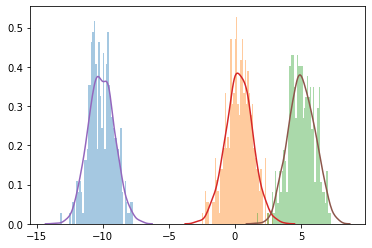

In [2]:
### credits to Tony Chen
from VI_GMM_demo_pytorch import VI_GMM_demo
VI_GMM_demo()

## 5.2 Variational Inference applied to Ising Model
Here, we will discuss how VI can be applied to Ising model, which is a canonical Markov Random Field (MRF) or undirected graphical model.

<figure>
    <img src="figures/Ising-model.png" width=300 height=300 title="Ising Model"/>
    <div style='width: 280; text-align: center;'>Ising Model</div>
</figure>

Let's quickly discuss what is what:
1. $x$ - hidden pixel values of "clean" image.
2. $y$ - noisy observations, what we really observe.

Let's describe distributions and a joint model:
\begin{align*}
p(x) = \frac{1}{Z_0} \exp(\sum_{i=1}^{D}\sum_{j \in Nbr(i)} x_i w_{ij} x_j) = \frac{1}{Z_0} \exp(\sum_{i,j \in E} x_i w_{ij} x_j) \\
p(y_i|x_i) = L(x_i) = N(y_i|x_i,\sigma^2)
\end{align*}

We are interested in "clean", denoised image, which means we are interested in $p(x|y)$. Unfortunately, true posterior is hard to compute (as we need to do summations of order $2^{D}$ to compute normalisation constant). We will use variational inference instead. 

Our variational distribution $q(x)$ will follow mean-field assumption: $q(x) = \prod_{i=1}^{D}q_i(x_i)$.
Each $q_i(x_i)$ is Bernoulli-like random variable: it takes value $+1$ with probability $q_i(x_i=+1)$ and value $-1$ with probability $q_i(x_i=-1)$. We are interested in its mean value, which we denote by $\mu_i$.

We can use a recipe, which we developed previously, namely: $q_i(x_i) \propto \exp(\mathbb{E}_{q(x_{-j})}[\log p(y,x)])$. Once some algebra is used (and $w_{ij}$ is fixed as $J$ for all $i,j$), we arrive at (almost) final form:
\begin{equation*}
  q_i(x_i) \propto \exp(x_i \sum_{j \in Nbr(i)} J\mu_j + \log N(y_i|x_i,\sigma^2))
\end{equation*}

Since $q_i(x_i$) is binary random variable, it is relatively straighforward to compute $q_i(x_i = +1)$ and $q_i(x_i = -1)$. You can consult K.Murphy or just use the equations below ($\sigma(x)$ is sigmoid function):
\begin{align*}
m_i = \sum_{j \in Nbr(i)} J \mu_{j} \\
L_{i}^{+} = \log N(y_i|x_i=+1,\sigma^2) \\
L_{i}^{-} = \log N(y_i|x_i=-1,\sigma^2) \\
a_i = m_i +0.5(L_{i}^{+} - L_{i}^{-}) \\
q_i(x_i=+1) = \sigma(2a_i) \\
q_i(x_i=-1) = \sigma(-2a_i) \\
\mu_i = tanh(a_i)
\end{align*}

The ELBO will take the following form:
$ELBO = \mathbb{E}_{q(x)}[\log p(y,x)] - \mathbb{E}_{q(x)}[\log q(x)] = \mathbb{E}_{q(x)}[\sum_{i,j \in E} x_i J x_j + \sum_{i=1}^{D} \log N(y_i|x_i,\sigma^2)] - \sum_{i=1}^{D}\mathbb{E}_{q_i(x_i)}[\log q_i(x_i)]$


  0%|          | 0/50 [00:00<?, ?it/s]

Size of image: 310-by-419


100%|██████████| 50/50 [07:05<00:00,  8.51s/it]


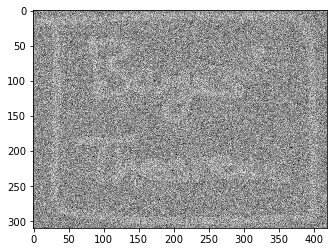

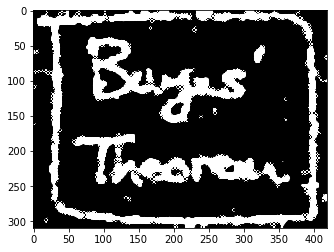

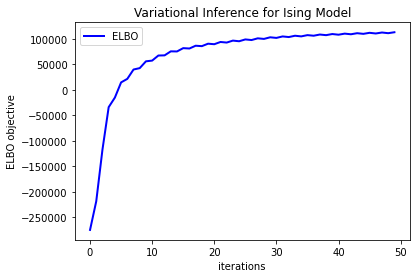

In [3]:
### lets try VI on Ising Model: inspired by Vadim Smolyakov
from VI_Ising_Model_demo import VI_Ising_Model_demo

VI_Ising_Model_demo(noise_level=3.5,J=1.0,n_iter=50)

## 6. From Mean-field VI to Stochastic VI
So far, we have seen how Mean-Field approach helped us solve some problems using Variational Inference.
In this chapter we look at how Variational Lower Bound is optimised in presence of not just variational parameters ($\phi$) but also model parameters ($\theta$).
Our objective is:
\begin{equation*}
  \underset{\theta,\phi}max\mathbb{F}(y,\theta,\phi)=\mathbb{E}_{q(z|x;\phi)}[\log p(y|z;\theta)] - KL(q(z|x;\phi)||p(z))
\end{equation*}
Let's try to demystify terms such as **Variational EM (VEM)**, **Stochastic Variational Inference (SVI)** and **Doubly Stochastic Variational Inference**.

Recipe for **VEM**:
1. E-step: for each datapoint $n=1 \cdots N$, do the update as: $\phi_{n} \propto \nabla_{\phi}\mathbb{E}_{q(z|x;\phi)}[\log p(y_n|z_n;\theta)] - \nabla_{\phi}KL(q(z_n|x;\phi)||p(z_n))$
2. M-step: do the update for $\theta$: $\theta \propto \frac{1}{N} \sum_n \mathbb{E}_{q(z|x;\phi)}[\nabla_{\theta}\log p(y_n|z_n;\theta)]$

**VEM** assumes you can compute expected log-likelihood and KL-term easily. For **SVI** you don't use the entire dataset, but use mini-batches of data to do the updates (good for big data!).

**Doubly Stochastic Variational Inference** not only takes mini-batching into account but also Monte-Carlo evaluation of expectation (and KL-term). This is why it is called **doubly stochastic**. E-step becomes:
$\phi_n \propto \nabla_{\phi} \frac{1}{S} \sum_{s=1}^{S}[\log p(y_n|z_n^{s};\theta) - \log \frac{q(z_n^{s})}{p(z_n^{s})}]$, where $z_n^{s} \sim q(z_n|y_n)$

Few **important** things:
1. What would we want ideally? We would want to avoid doing E-step for all datapoints seperately.
2. How? Use global parameters $\phi$ for all data points. Think of encoder Neural Network in Variational Autoencoder (VAE) architecture.
3. Advantages? Can optimize parameters $\phi$ and $\theta$ jointly. Combines easily with mini-batching and MC estimates (so, it is still a **doubly stochastic** inference).

Computing gradients w.r.t $\theta$ is easy, but situation with gradients w.r.t $\phi$ is different: $\nabla_{\phi}\mathbb{E}_{q(z|x;\phi)}[\log p(y|z;\theta)]$.
There are few solutions:
1. **Log-derivative trick**. Works with both discrete and continuous variables. High variance of stochastic gradients. 
\begin{eqnarray}
    \nabla_{\phi} \mathbb{E}_{q_{\phi}(z)}[f(z)] = \mathbb{E}_{q_{\phi}(z)}[f(z) \nabla_{\phi} \log q_{\phi}(z)] \approx \frac{1}{L} \sum_{l=1}^{L} f(z^{l}) \nabla_{\phi} \log q_{\phi}(z^{l}) \\
    \text{where $z^{l} \sim q_{\phi}(z)$} \notag
\end{eqnarray}

2. **Reparametrisation trick** with a deterministic transformation ($g_{\phi}(\cdot)$) of one random variable into another. Low-variance gradients. Does not work with some distributions.
\begin{eqnarray}
    \nabla_{\phi} \mathbb{E}_{q_{\phi}(z)}[f(z)] = \nabla_{\phi} \mathbb{E}_{p(\epsilon)}[f(g_{\phi}(\epsilon))] \approx \frac{1}{L} \sum_{l=1}^{L} \nabla_{\phi} f(g_{\phi}(\epsilon^{l})) \\
    \text{where $\epsilon^{l} \sim p(\epsilon)$} \notag
\end{eqnarray}

<figure>
    <img src="figures/reparameterization-trick.png" width=300 height=300 title="Reparameterization Trick"/>
    <div style='width: 280; text-align: center;'>Reparameterization Trick</div>
</figure>

What to do if you want to use say, Dirichlet, distribution or a discrete distribution in your model?
1. For (almost?) all continuous distributions [implicit reparametrisation gradients](https://arxiv.org/abs/1805.08498) are available in modern Deep Learning libraries. In Pytorch you just need to use method **rsample()**. This means it is straightforward to use (almost?) any continuous distribution in your code!
2. For categorical (discrete) distributions one can use [Gumbel-Softmax reparametrisation](https://arxiv.org/abs/1611.01144).

## 6.1 SVI Pytorch example on 1D dataset
Here, we have an independent variable $x$ and a dependent variable $y$.
Our model will be the following: $p(y|x) \propto p(x|y)p(y)$.
We assume that prior $p(y)$ is $N(0,1)$.

Since, we are doing VI, we cannot obtain true p(y|x). We will approximate it with variational (Gaussian) distribution $q_{\theta}(y)$, where $\theta$ are parameters of variational distribution that will be learnt by a Neural Network.

Epoch:0, ELBO:7.9642
Epoch:500, ELBO:1.1785
Epoch:1000, ELBO:1.1894
Epoch:1500, ELBO:1.0956
Epoch:2000, ELBO:1.1096
Epoch:2500, ELBO:1.1232
Epoch:3000, ELBO:1.1192
Epoch:3500, ELBO:1.1819
Epoch:4000, ELBO:1.1277
Epoch:4500, ELBO:1.1516


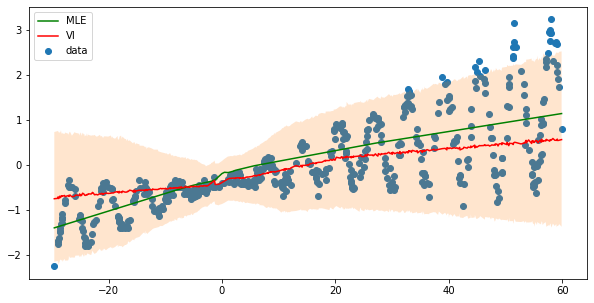

In [1]:
### credits to Ritchie Vink
from VI_with_NN_simple_example_pytorch import VI_simple_demo_NN
VI_simple_demo_NN()

## 6.2 Backpropagation using discrete distributions
When we talk about incorporating discrete (categorical) distributions into computation graphs, we want to have the same picture as with Reparametrization trick with Gaussian: **sample from some random noise and then transform this random noise deterministically into a desired sample**.
Here is an idea from [one of two papers that introduces Gumbel-Softmax trick](https://arxiv.org/pdf/1611.00712.pdf):
<figure>
    <img src="figures/relaxation-of-categorical-distribution.png" width=700 height=700 title="Reparameterization Trick for Categorical distribution"/>
    <div style='width: 280; text-align: center;'>Reparameterization Trick for Categorical distribution</div>
</figure>

So what exactly do we see here?
1. On the LHS, we can sample discrete RVs using continuous RVs (as noise) through argmax operation.
2. On the RHS, we replace non-differentiable argmax with differentiable softmax, which will allow nice backpropagation.

For **very keen** people either read below or follow [this](https://lips.cs.princeton.edu/the-gumbel-max-trick-for-discrete-distributions/):
1. PDF of Gumbel: $\exp(-x \exp(-x))$
2. CDF of Gumbel: $\exp(-\exp(-x))$
3. We have one-hot encoded vector $z$:
    - Example $(0,0,0,1,0)$ with $k=5$. 
    - $\sum_{j=1}^{K}z_j = 1$ (only one element in vector equals to 1). 
    - $\mathbb{P}(z_k=1)=\alpha_k$; $\forall \alpha_j \geq 0$; $\sum_{j=1}^{K}\alpha_j = 1$
4. Introduce Gumbel RV:
    - $x_j \sim \text{Gumbel}$
    - $z_k = 1$ if $k=\underset{j}{\text{argmax}}(x_j+\log \alpha_j)=\underset{j}{\text{argmax}}(u_j)$
5. We need to show that $\mathbb{P}(z_k=1)=\alpha_k$
6. At some point we will need this:
    - $F_{X}(t)$ and $f_{X}(t)$ are known for RV $X$.
    - $U=X+\alpha$, where $\alpha$ is some constant.
    - $F_{U}(t)=\mathbb{P}(U<t)=\mathbb{P}(X+\alpha<t)=\mathbb{P}(X<t-\alpha)=F_{X}(t-\alpha)$
    - Consequently, $p_{U}(t)=p_{X}(t-\alpha)$

**Proof**:
\begin{equation}
\begin{split}
\mathbb{P}(z_k=1)=\int [\prod_{j \neq k} \mathbb{P}(u_j<u_k)] p_{u_k}(u_k)du_k = \\
= \int [\prod_{j \neq k} \mathbb{P}(x_j+\log \alpha_j<u_k)] p_{u_k}(u_k)du_k = \\
=  \int [\prod_{j \neq k} \mathbb{P}(x_j<u_k-\log \alpha_j)] p_{u_k}(u_k)du_k = \\
=  \int [\prod_{j \neq k} \exp(-\exp(-u_k+\log \alpha_j)) p_{x_k}(u_k - \log \alpha_k) du_k = \\
=  \int [\prod_{j \neq k} \exp(-\exp(-u_k+\log \alpha_j)) \exp(-u_k+\log \alpha_k -\exp(-u_k+\log \alpha_k)) du_k = \\
=  \int [\prod_{j \neq k} \exp(-\alpha_j \exp(-u_k))] \alpha_k \exp(-u_k-\alpha_k \exp(-u_k)) du_k = \\
=  \int \alpha_k \exp(-u_k - (\sum_{j}\alpha_j)\exp(-u_k))du_k = \\
=  \alpha_k \int \exp(-u_k - \exp(-u_k))du_k = \alpha_k \\
\end{split}
\end{equation}


Our probabilities vector with 7 categories: [0.12753624 0.11304348 0.09565217 0.17391305 0.1826087  0.2289855
 0.07826087]


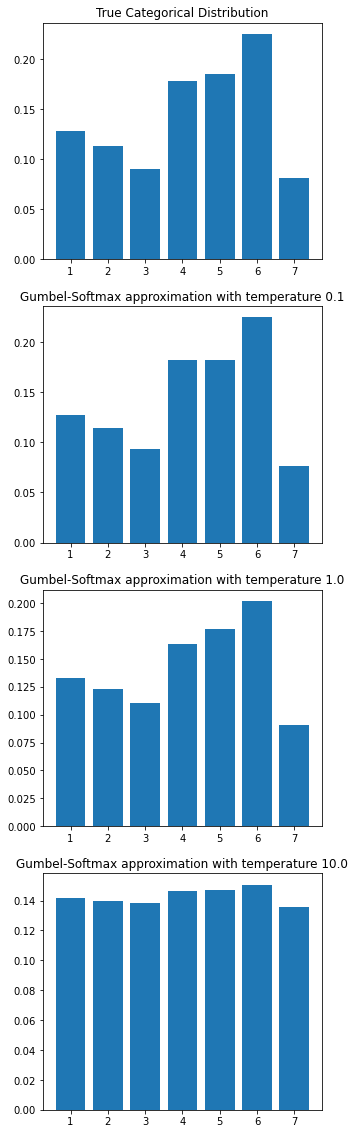

In [4]:
from Gumbel_Softmax_Approximation import gumbel_softmax_demo
gumbel_softmax_demo(
                        seed         = 0,
                        n_samples    = 5000,
                        k            = 7,
                        temperatures = [0.1,1.0,10.0]
                   ) # 5000 samples and 7 categories

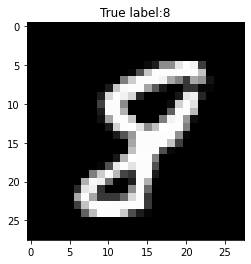

Epoch:0 (# of batch updates:469), ELBO:200.1624, Temperature:0.9930


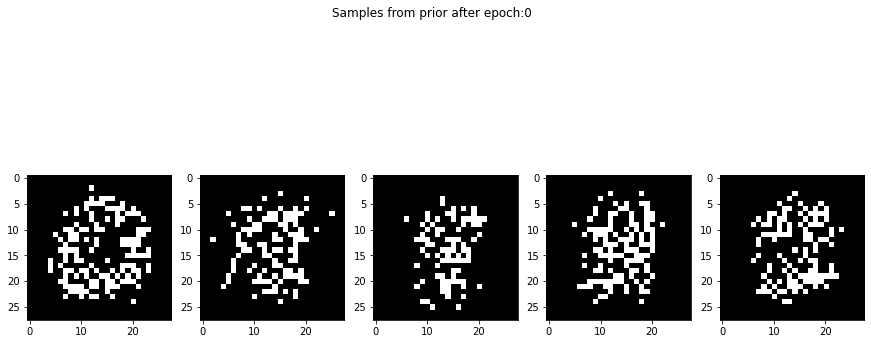

Epoch:1 (# of batch updates:938), ELBO:179.0897, Temperature:0.9791
Epoch:2 (# of batch updates:1407), ELBO:167.0774, Temperature:0.9655
Epoch:3 (# of batch updates:1876), ELBO:160.7278, Temperature:0.9520
Epoch:4 (# of batch updates:2345), ELBO:156.5906, Temperature:0.9387
Epoch:5 (# of batch updates:2814), ELBO:153.1602, Temperature:0.9256
Epoch:6 (# of batch updates:3283), ELBO:150.8380, Temperature:0.9126
Epoch:7 (# of batch updates:3752), ELBO:148.8347, Temperature:0.8999
Epoch:8 (# of batch updates:4221), ELBO:147.0212, Temperature:0.8873
Epoch:9 (# of batch updates:4690), ELBO:145.4321, Temperature:0.8749
Epoch:10 (# of batch updates:5159), ELBO:144.0018, Temperature:0.8627


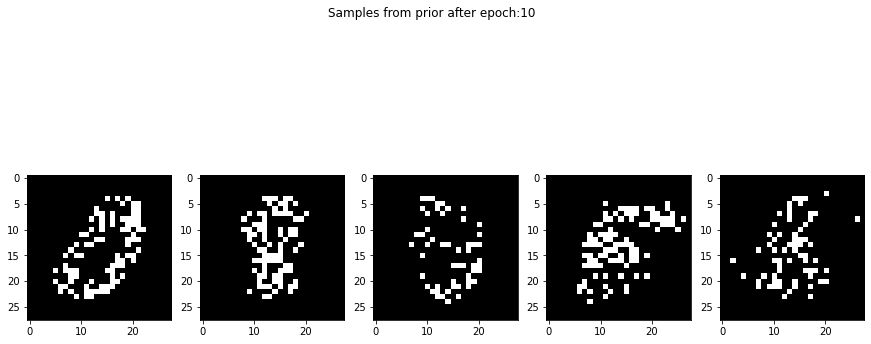

Epoch:11 (# of batch updates:5628), ELBO:142.9362, Temperature:0.8506
Epoch:12 (# of batch updates:6097), ELBO:142.1201, Temperature:0.8387
Epoch:13 (# of batch updates:6566), ELBO:141.3823, Temperature:0.8270
Epoch:14 (# of batch updates:7035), ELBO:140.7413, Temperature:0.8155
Epoch:15 (# of batch updates:7504), ELBO:140.1364, Temperature:0.8041
Epoch:16 (# of batch updates:7973), ELBO:139.5851, Temperature:0.7928
Epoch:17 (# of batch updates:8442), ELBO:139.0566, Temperature:0.7818
Epoch:18 (# of batch updates:8911), ELBO:138.6630, Temperature:0.7708
Epoch:19 (# of batch updates:9380), ELBO:138.3501, Temperature:0.7601
Epoch:20 (# of batch updates:9849), ELBO:137.9288, Temperature:0.7495


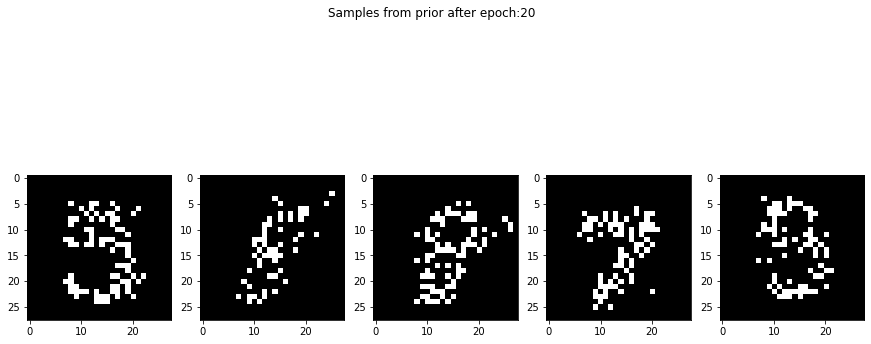

Epoch:21 (# of batch updates:10318), ELBO:137.6552, Temperature:0.7390
Epoch:22 (# of batch updates:10787), ELBO:137.3563, Temperature:0.7287
Epoch:23 (# of batch updates:11256), ELBO:137.1886, Temperature:0.7185
Epoch:24 (# of batch updates:11725), ELBO:136.9194, Temperature:0.7084
Epoch:25 (# of batch updates:12194), ELBO:136.7757, Temperature:0.6985
Epoch:26 (# of batch updates:12663), ELBO:136.4952, Temperature:0.6888
Epoch:27 (# of batch updates:13132), ELBO:136.2517, Temperature:0.6792
Epoch:28 (# of batch updates:13601), ELBO:136.0756, Temperature:0.6697
Epoch:29 (# of batch updates:14070), ELBO:135.9202, Temperature:0.6603
Epoch:30 (# of batch updates:14539), ELBO:135.7883, Temperature:0.6511


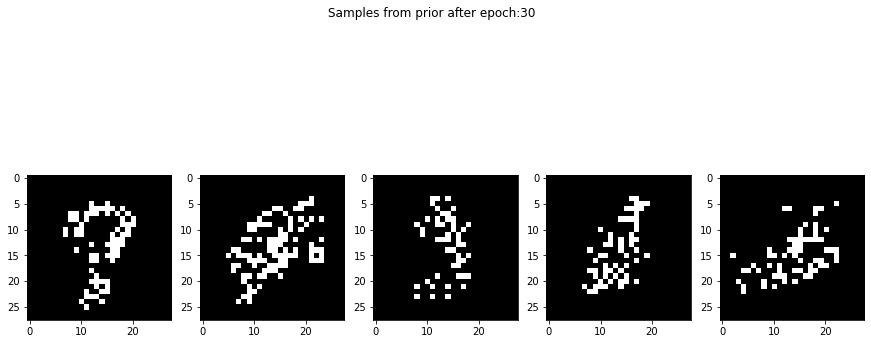

Epoch:31 (# of batch updates:15008), ELBO:135.6023, Temperature:0.6420
Epoch:32 (# of batch updates:15477), ELBO:135.4873, Temperature:0.6330
Epoch:33 (# of batch updates:15946), ELBO:135.3245, Temperature:0.6242
Epoch:34 (# of batch updates:16415), ELBO:135.1232, Temperature:0.6155
Epoch:35 (# of batch updates:16884), ELBO:135.0155, Temperature:0.6069
Epoch:36 (# of batch updates:17353), ELBO:134.9194, Temperature:0.5984
Epoch:37 (# of batch updates:17822), ELBO:134.6958, Temperature:0.5900
Epoch:38 (# of batch updates:18291), ELBO:134.6040, Temperature:0.5818
Epoch:39 (# of batch updates:18760), ELBO:134.4836, Temperature:0.5736
Epoch:40 (# of batch updates:19229), ELBO:134.3566, Temperature:0.5656


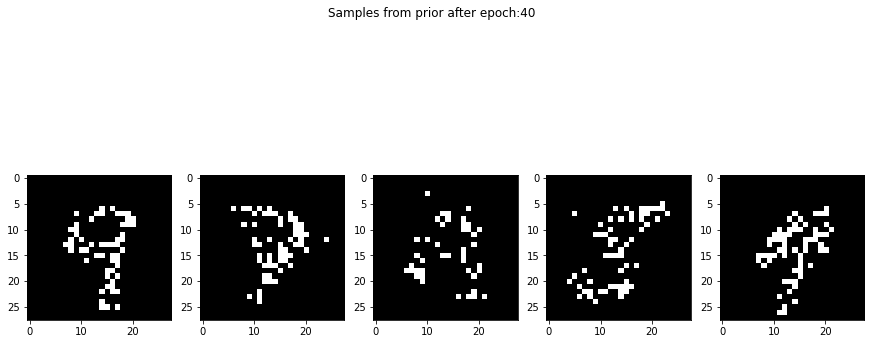

Epoch:41 (# of batch updates:19698), ELBO:134.2690, Temperature:0.5577
Epoch:42 (# of batch updates:20167), ELBO:134.2194, Temperature:0.5499
Epoch:43 (# of batch updates:20636), ELBO:134.0874, Temperature:0.5423
Epoch:44 (# of batch updates:21105), ELBO:134.0666, Temperature:0.5347
Epoch:45 (# of batch updates:21574), ELBO:134.0073, Temperature:0.5272
Epoch:46 (# of batch updates:22043), ELBO:133.9580, Temperature:0.5198
Epoch:47 (# of batch updates:22512), ELBO:133.9087, Temperature:0.5126
Epoch:48 (# of batch updates:22981), ELBO:133.8068, Temperature:0.5054
Epoch:49 (# of batch updates:23450), ELBO:133.8035, Temperature:0.4984
Epoch:50 (# of batch updates:23919), ELBO:133.7695, Temperature:0.4914


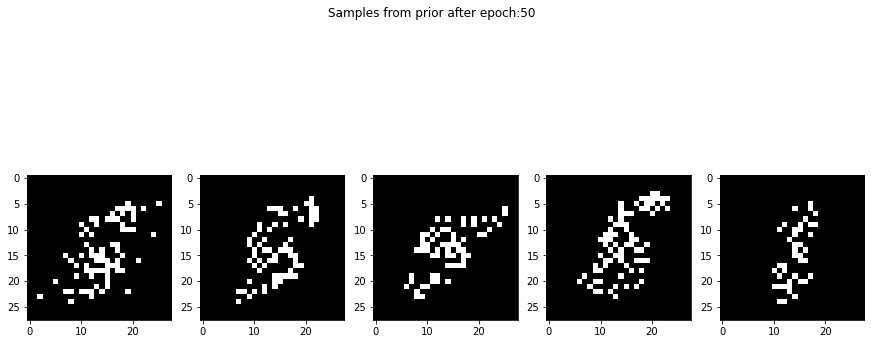

Epoch:51 (# of batch updates:24388), ELBO:133.6914, Temperature:0.4845
Epoch:52 (# of batch updates:24857), ELBO:133.6524, Temperature:0.4778
Epoch:53 (# of batch updates:25326), ELBO:133.6274, Temperature:0.4711
Epoch:54 (# of batch updates:25795), ELBO:133.5765, Temperature:0.4645
Epoch:55 (# of batch updates:26264), ELBO:133.5160, Temperature:0.4580
Epoch:56 (# of batch updates:26733), ELBO:133.4645, Temperature:0.4516
Epoch:57 (# of batch updates:27202), ELBO:133.4369, Temperature:0.4453
Epoch:58 (# of batch updates:27671), ELBO:133.3820, Temperature:0.4391
Epoch:59 (# of batch updates:28140), ELBO:133.3756, Temperature:0.4329
Epoch:60 (# of batch updates:28609), ELBO:133.3736, Temperature:0.4269


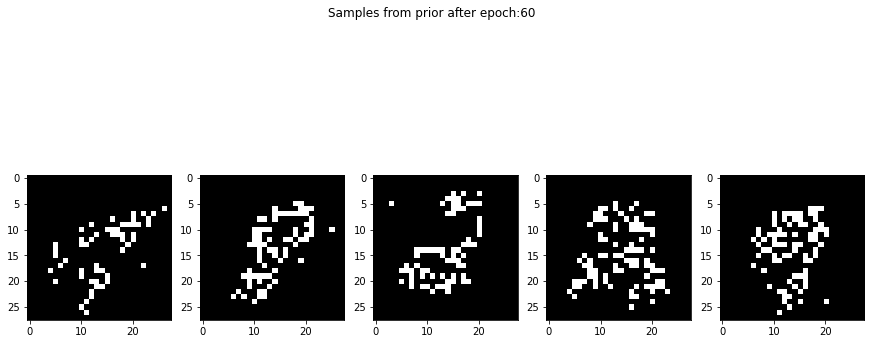

Epoch:61 (# of batch updates:29078), ELBO:133.3279, Temperature:0.4209
Epoch:62 (# of batch updates:29547), ELBO:133.2838, Temperature:0.4151
Epoch:63 (# of batch updates:30016), ELBO:133.2219, Temperature:0.4093
Epoch:64 (# of batch updates:30485), ELBO:133.1767, Temperature:0.4035
Epoch:65 (# of batch updates:30954), ELBO:133.2339, Temperature:0.3979
Epoch:66 (# of batch updates:31423), ELBO:133.2136, Temperature:0.3923
Epoch:67 (# of batch updates:31892), ELBO:133.1899, Temperature:0.3869
Epoch:68 (# of batch updates:32361), ELBO:133.2417, Temperature:0.3815
Epoch:69 (# of batch updates:32830), ELBO:133.1439, Temperature:0.3761
Post-training samples


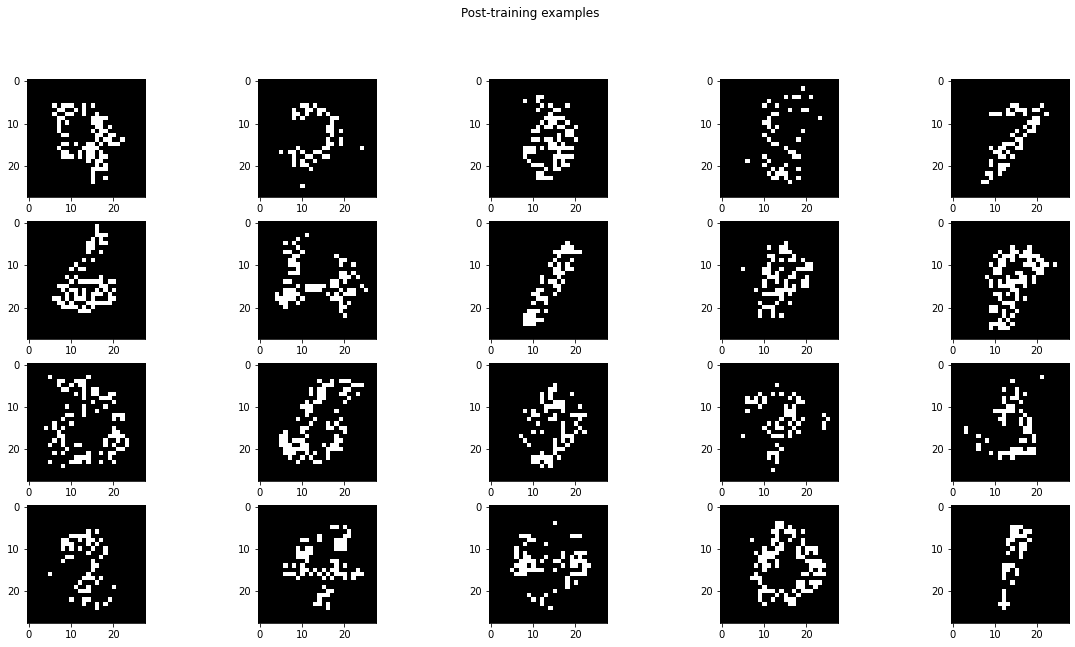

In [3]:
### demo of discrete VAE
#%matplotlib inline

from VI_Discrete_VAE_example_pytorch import discrete_vae_demo

# set params
N             = 70
NUM_EPOCHS    = 70
freq          = 10
init_temp     = 1.0
ANNEAL_RATE   = 0.00003
MIN_TEMP      = 0.15

discrete_vae_demo(
                    N           = N,
                    NUM_EPOCHS  = NUM_EPOCHS,
                    freq        = freq,
                    init_temp   = init_temp,
                    ANNEAL_RATE = ANNEAL_RATE,
                    MIN_TEMP    = MIN_TEMP
                 )

## 7. Application of VI to enzyme engineering
My PhD project deals with application of generative deep learning models (we use VAEs) to enzyme engineering. To put it simply, I try to train VAE on a set of known proteins. Once trained I obtain novel variants of proteins of interest. I am particularly interested in enzymes (proteins that catalyze certain reactions in cells) that are involved in certain disease development.

**Why do I do this?**
1. Certain diseases (e.g., Gaucher's disease) require life-long injection of **synthetic enzymes**.
2. These synthetic enzymes are expensive, immunogenic and, most importantly, their catalytic activity does not match the wild-type (WT) level.
3. Traditional approaches to develop synthetic enzymes are time-consuming.
4. AI offers an alternative (and, hopefully, faster) way to develop such synthetic enzymes.

**How do I do this?**
1. Train VAE on a set of proteins. I use Gaussian and Dirichlet distributions for latent space.
2. Sample from variational posterior distribution $q(z|y)$ and decode this sample through a decoder NN.
3. Computationally analyze novel variants.
4. Test them in the lab.

**What results have I achieved?**
1. Around 97-99% identity of VAE samples to WT enzyme with.
2. Important regions remain unchanged in VAE samples.
3. Contact maps (2D representation of 3D structure) of VAE samples look like WT.

<figure>
    <img src="figures/VAE-samples-contact-maps.png" width=500 height=500 title="Contact maps for SP1L HUMAN VAE samples vs WT"/>
    <div style='width: 280; text-align: center;'>Contact maps for SP1L HUMAN VAE samples vs WT</div>
</figure>

